# 10.2 Image processing

**Today's class:**

* Image Processing for fun and science!
    - image basics
    - linear image filters
    - other filters (median)
    - histograms and statistics

## Image processing
**Contributed by William Thompson**


Image processing is a domain of computer science that is very relevant for scientists and mathematicians. Much of the data we gather about the world comes from, or at least originates, from images. This is quite apparent when considering astronomy, but scientific imaging is also widely used in biology, medicine, geophyics, and many other domains.

Considering astronomy, here is an example from my own research:

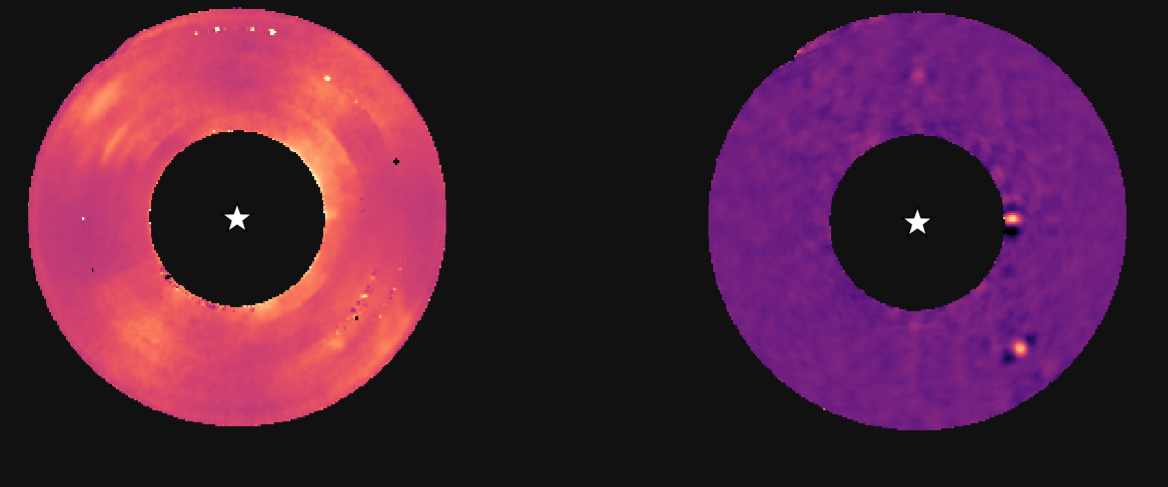

**Left**: 80 near-infrared images of a nearby solar system that have been combined by averaging them. The dark circle in the middle is where the bright light of the star has been blocked by a coronagraph.

**Right**: The *same* images, combined using advanced image processing techniques to reveal three giant exoplanets!

-----

Most image processing is really the combination of:
* Programming
* Statistics
* Linear Algebra
* Vector calculus 


At the end of this lecture and excercise, you will learn:
* How to represent an image file as a numpy array
* How to create and understand a histogram of an image
* How to apply basic transformations and filters


We will revsit:
* Linear transformations (lecture 8)
* Histograms
* Gaussian functions

-----

For these excercises we will mostly be using the Scikit-Images library, which contains some sample images.

In image processing communities, there are several _standard_ images which are used to compare alogrithms. In this case, we will use `astronaut`. These usually contain a nice mix of colours and areas with different textures. e.g. compare the astronauts hair to the smooth helmet.

This particular photo, `astronaut`, is of Eileen Collins. She was the first woman to pilot and command the space shuttle for NASA.

In [1]:
%pylab ipympl

Populating the interactive namespace from numpy and matplotlib


In [2]:
import skimage.data
import scipy.ndimage
import scipy.ndimage.filters

In [3]:
# Get the sample image
img = skimage.data.astronaut()

> There are a few others as well:
> https://scikit-image.org/docs/stable/auto_examples/

The image is in fact just a numpy array!

It is three dimensional: 512x512 spatial pixels, with 3 different colors: red, green, and blue.

Grayscale images have only one channel, whereas color images traditionally have three, and graphics intended for printers have four.
In astronomy, it is common to encounter images with 100s of different color channels representing different wavelenths of light.

In [4]:
shape(img)

(512, 512, 3)

In [5]:
img[0:10,0:10,0]

array([[154, 109,  63,  54,  76, 100, 124, 139, 148, 141],
       [177, 144, 113, 106, 128, 148, 163, 170, 173, 159],
       [201, 182, 168, 159, 167, 186, 190, 192, 183, 163],
       [220, 214, 202, 197, 200, 202, 205, 198, 181, 149],
       [232, 226, 221, 215, 221, 212, 212, 194, 168, 131],
       [236, 235, 229, 226, 224, 216, 202, 181, 151, 108],
       [235, 237, 233, 228, 221, 212, 191, 168, 129,  81],
       [232, 235, 231, 225, 216, 207, 188, 154, 107,  55],
       [229, 231, 229, 222, 215, 204, 184, 150, 102,  49],
       [227, 228, 224, 219, 214, 204, 184, 156, 114,  69]], dtype=uint8)

Notice the data type on the bottom right! Images require quite a lot of data, so they are often stored using single unsigned bytes. That means each pixel (of each color) is represented by a number between 0 and 255. 0 is black, and 255 is bright white.


"Scientific" images are often stored instead as 32-bit floating point values. These take up 4x as much room, but allow for negative and fractional values which are quite convinient.

Note: The usual data type we use in python for math are 64-bit floating point values. This is almost always overkill for image data, and until recently, most GPUs worked only/best with 32-bit data.

Since images originate from camera sensors, using 64 bits would imply that each pixel can differentiate $2^{64}$ different intensities of light! This is not possible with all but the most specialized equipment.
The human eye, on the other hand, can function across a range of $2^{21}$ different intensities (though not precisely measure all 2^21 values in between).

### Image Basics
#### Displaying Images

We can display the image using the matplotlib function `imshow`

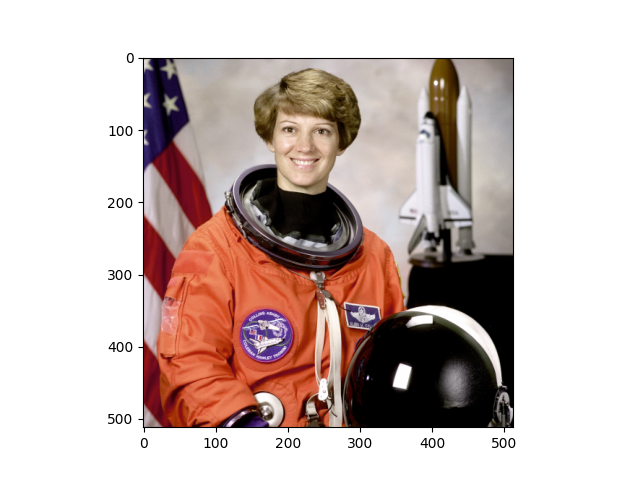

In [6]:
ifig=1;close(ifig);figure(ifig)

imshow(img)

We can extract the the red color channel as a 2D array:

Text(0.5, 1.0, 'BLUE')

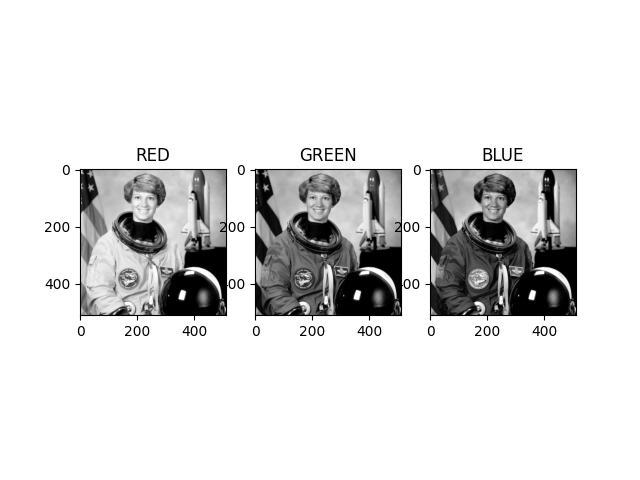

In [7]:
r = img[:,:,0]
g = img[:,:,1]
b = img[:,:,2]

ifig=2;close(ifig);figure(ifig)

subplot(1,3,1,sharex=gca(), sharey=gca())
imshow(r, cmap="gray", vmin=0, vmax=255)
title("RED")

subplot(1,3,2,sharex=gca(), sharey=gca())
imshow(g, cmap="gray", vmin=0, vmax=255)
title("GREEN")

subplot(1,3,3,sharex=gca(), sharey=gca())
imshow(b, cmap="gray", vmin=0, vmax=255)
title("BLUE")

Text(0.5, 1.0, 'BLUE')

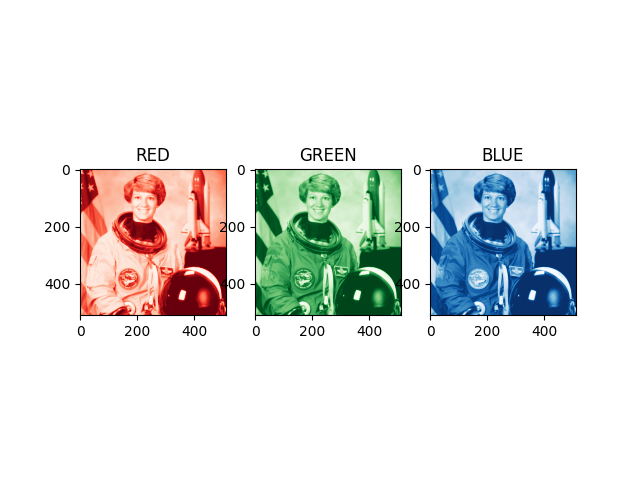

In [8]:
r = img[:,:,0]
g = img[:,:,1]
b = img[:,:,2]

ifig=2;close(ifig);figure(ifig)

subplot(1,3,1,sharex=gca(), sharey=gca())
imshow(r, cmap="Reds_r", vmin=0, vmax=255)
title("RED")

subplot(1,3,2,sharex=gca(), sharey=gca())
imshow(g, cmap="Greens_r", vmin=0, vmax=255)
title("GREEN")

subplot(1,3,3,sharex=gca(), sharey=gca())
imshow(b, cmap="Blues_r", vmin=0, vmax=255)
title("BLUE")

Conceptually, this array is just a matrix that we can manipulate. Note that we mean a matrix in the mathematical sense, not a numpy matrix object.

Here, we are using different colormaps for each image. But, really, they are each grey. Try changing the cmap to "gray" (american spelling)



<br>

Let's increase the exposure by multiplying each value by a constant

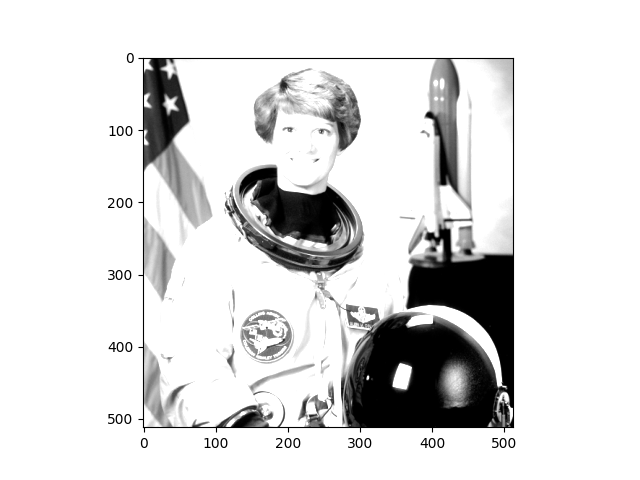

In [17]:
brighter = r*1.5

ifig=3;close(ifig);figure(ifig)
imshow(brighter,cmap='gray', vmin=0, vmax=255)

#### Linear Image Filters

We can manipulate images in many ways by applying *filters*. Normally, this is done with the convolution operator.

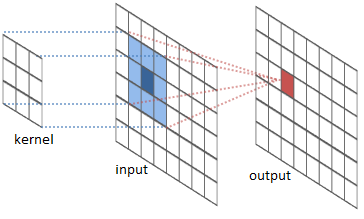

By convolving one image with another matrix (called a kernel), we can apply linear filters. These are filters that replace one pixel with a linear combination of values from the surrounding pixels. 

Essentially, we step across each pixel of the image and replace it with a value determined from its neighboring pixels.
For convolution (instead of correlation) we actually flip the kernel. The details of why will not be important for today.


Note: One nice property of linear filters is that they can be chained together and applied in one go.

In [19]:
# The identity kernel. Make no change to the image
kern_example = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
])

data_example = np.array([
    [1, 1, 1],
    [1, 2, 1],
    [1, 1, 1]
])


filt_examp = scipy.ndimage.filters.convolve(data_example, kern_example)

print("Kernel")
print(kern_example)

print("\nBefore")
print(data_example)

print("\nAfter")
print(filt_examp)

Kernel
[[0 0 0]
 [0 1 0]
 [0 0 1]]

Before
[[1 1 1]
 [1 2 1]
 [1 1 1]]

After
[[2 2 2]
 [2 3 2]
 [2 2 3]]


Text(0.5, 1.0, 'AFTER')

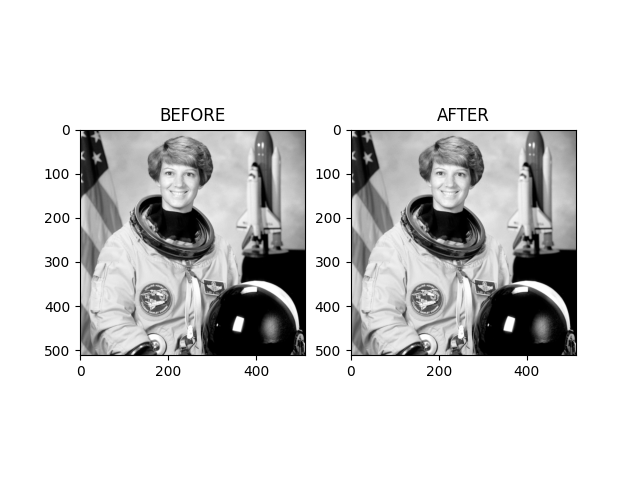

In [20]:
# The identity kernel. Make no change to the image
kern_ident = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0],
])


filtered1 = scipy.ndimage.filters.convolve(r, kern_ident)

ifig=4;close(ifig);figure(ifig)
subplot(1,2,1)
imshow(r, cmap="gray")
title("BEFORE")
subplot(1,2,2,sharex=gca(), sharey=gca())
imshow(filtered1, cmap="gray")
title("AFTER")

There is no change. We replaced each pixel with its own value.

#### Translation

Text(0.5, 1.0, 'AFTER')

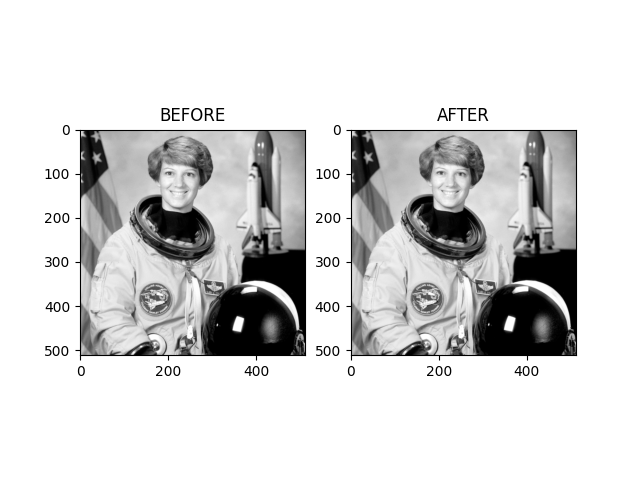

In [25]:
# Move the image one pixel up and one pixel to the left (recall, kernels are flipped).
kern_translate = np.array([
    [0, 0, 1],
    [0, 0, 0],
    [0, 0, 0],
])


filtered1 = scipy.ndimage.filters.convolve(r, kern_translate)

ifig=5;close(ifig);figure(ifig)
subplot(1,2,1)
imshow(r, cmap="gray")
title("BEFORE")
subplot(1,2,2,sharex=gca(), sharey=gca())
imshow(filtered1, cmap="gray")
title("AFTER")

# NOTE: Try zooming

In [24]:
# Zoom in on eye
xlim((239.50784890851116, 258.3452293352956))
ylim((114.74354652218769, 94.33638439317122))

(114.74354652218769, 94.33638439317122)

#### Bluring

Here is a function we have seen before! A Gaussian.
A 2D Gaussian, discretized into a matrix looks like this:

<img src="https://homepages.inf.ed.ac.uk/rbf/HIPR2/figs/gausmask.gif"/>


Larger $\sigma$ values lead to more bluring. As you increase $\sigma$, you should also increase the size of the kernel matrix to properly capture the function and avoid artifacts.

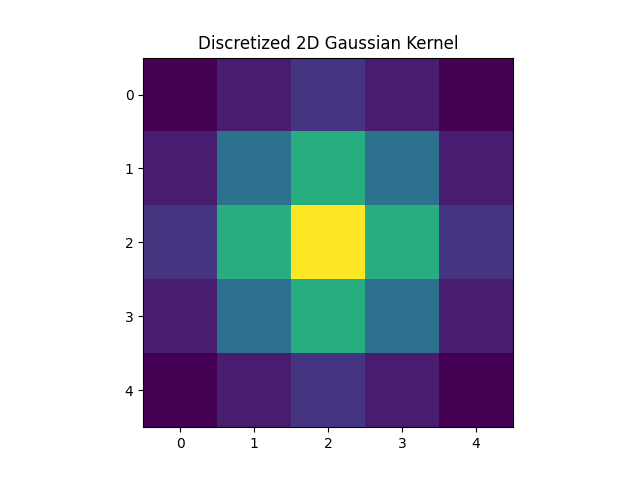

In [26]:
kern_blur = np.array([
    [1,  4,  7,  4, 1],
    [4, 16, 26, 16, 4],
    [7, 26, 41, 26, 7],
    [4, 16, 26, 16, 4],
    [1,  4,  7,  4, 1],
])
kern_blur = kern_blur / sum(kern_blur)
ifig=61;close(ifig);figure(ifig)
imshow(kern_blur)
title("Discretized 2D Gaussian Kernel");

Text(0.5, 1.0, 'AFTER')

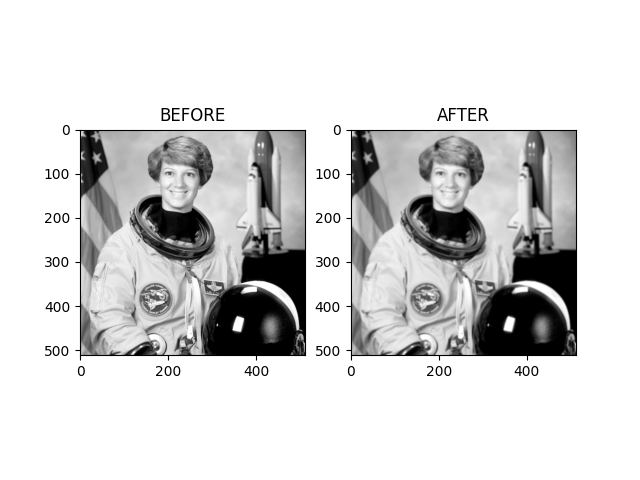

In [29]:
# Blur the image
kern_blur = np.array([
    [1,  4,  7,  4, 1],
    [4, 16, 26, 16, 4],
    [7, 26, 41, 26, 7],
    [4, 16, 26, 16, 4],
    [1,  4,  7,  4, 1],
])
kern_blur = kern_blur / sum(kern_blur)




filtered1 = scipy.ndimage.filters.convolve(r, kern_blur)

ifig=6;close(ifig);figure(ifig)
subplot(1,2,1)
imshow(r, cmap="gray")
title("BEFORE")
subplot(1,2,2,sharex=gca(), sharey=gca())
imshow(filtered1, cmap="gray")
title("AFTER")

In [28]:
xlim((143.75116507235714, 313.28758891341676))
ylim((126.11859210203579, 11.524527839097345))

(126.11859210203579, 11.524527839097345)

### Edge detection with Derivatives

If we think of an image as a function F(x,y) which is the intensity with respect to two 
coordinates, we can ask: can we perform other mathematical operations, like taking a derivative? The answer is yes!

What would a derivative mean for a image? 
If we take the derivative along one dimension of the image, we will get a new image where each pixel now represents the rate of change to intensity of the scene.
Higher values represent places where the intensity is changing the most rapidly.


> Note to the pedantic, I know we cannot formally take a derivative of a discrete function. We are assuming that these are point samples of an underlying continous function representing the intensity of the scene and approximating with finite differences.



We can leverage this to detect edges in images in images by taking partial derviatives of F with respect to x and y. In fact, we can do this using the same convolution with a kernel approach we used before.

<br>

**$F_x(x,y)$**

The kernel for the first order approximation to the partial derivative along the horizontal direction is given by:

$$\left(\begin{matrix}
1 & 0 & -1 \\
\end{matrix}\right)$$

Each pixel is replaced by the difference between the pixels to the left and to the right.

This will be quite sensitive to noise. We can add some smoothing in the opposite (vertical) direction to make it more robust.


The kernel for the first order approximation to the partial derivative along the horizontal direction is given by:

$$\left(\begin{matrix}
1 & 0 & -1 \\
2 & 0 & -2 \\
1 & 0 & -1 \\
\end{matrix}\right)$$

Each pixel is replaced by the difference between the pixels to the left and to the right. This is equivalent to smoothing with a 3-pixel gaussian vertically, and then taking the derivative horizontally (or vice-versa, they are linear filter).



**$F_y(x,y)$**

$$\left(\begin{matrix}
1 \\
0 \\
-1 \\
\end{matrix}\right)$$

Each pixel is replaced by the difference between the pixels above and below.

**Now as code:**

Text(0.5, 1.0, 'Vertical')

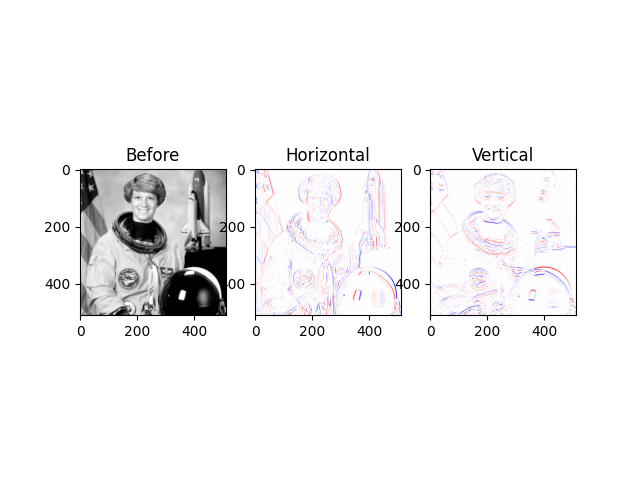

In [32]:
# Take the gradient in the horizontal direction
kern_edge_horiz = np.array([
    [1,  0, -1],
    [2,  0, -2],
    [1,  0, -1],
])

# Take the gradient in the vertical direction
kern_edge_vert = np.array([
    [ 1, 2,  1],
    [ 0, 0,  0],
    [-1,-2, -1],
])

# Note: to store negative values we must convert this to a better datatype
filteredhoriz = scipy.ndimage.filters.convolve(array(r,dtype=float), kern_edge_horiz)
filteredvert = scipy.ndimage.filters.convolve(array(r,dtype=float), kern_edge_vert)

ifig=7;close(ifig);figure(ifig)
subplot(1,3,1)
imshow(r, cmap="gray")
title("Before")
subplot(1,3,2,sharex=gca(), sharey=gca())
imshow(filteredhoriz, cmap="bwr", vmin=-700, vmax=700)
title("Horizontal")
subplot(1,3,3,sharex=gca(), sharey=gca())
imshow(filteredvert, cmap="bwr", vmin=-700, vmax=700)
title("Vertical")

In [31]:
# Zoom into model shuttle
xlim(349.10269360269365, 486.09163059163063)
ylim(309.1257816257816, 0)

(309.1257816257816, 0.0)

Now find the length of both directional derivatives to get the magnitude of the gradient. In image processing, this is called the **Sobel** filter. It can be used for detecting edges in images.

Text(0.5, 1.0, 'Gradient Magnitude')

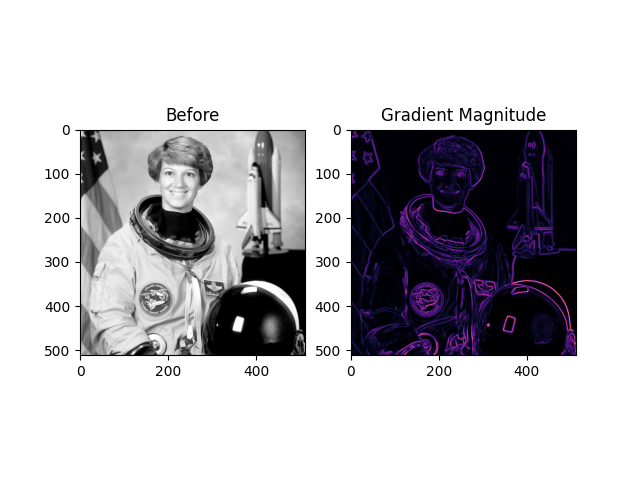

In [36]:
# Compute the magnitude of the gradient at each pixel (this is just the norm, or length, of the vector)
gradmag = sqrt(filteredhoriz**2 + filteredvert**2)

# Compute the direction using the inverse tangent function atan(y/x).
# We use the two-argument form to retain the quadrant information
gradangle= np.arctan2(filteredvert, filteredhoriz)



ifig=9; close(ifig);figure(ifig)
subplot(1,2,1)
imshow(r, cmap="gray")
title("Before")

subplot(1,2,2,sharex=gca(), sharey=gca())
imshow(gradmag, cmap="magma")
title("Gradient Magnitude")

Zoom in to checkout the helmet, where there is that rectangular reflection.

We see that the gradient of the image intensity (in the red channel) is high wherever there is a *transition* in brightness. This makes it a valuable tool for detecting edges.

---
Let's look at two components of the gradient: horizontal and vertical.

In [37]:
# Mask to show part of the helmet
ymask = arange(300,480)
xmask = arange(300,380)

# # Mask to only show the shuttle
ymask = arange(0,309)
xmask = arange(348,486)

# Convert two 1D masks into a 2D mask
mask = np.ix_(ymask,xmask)

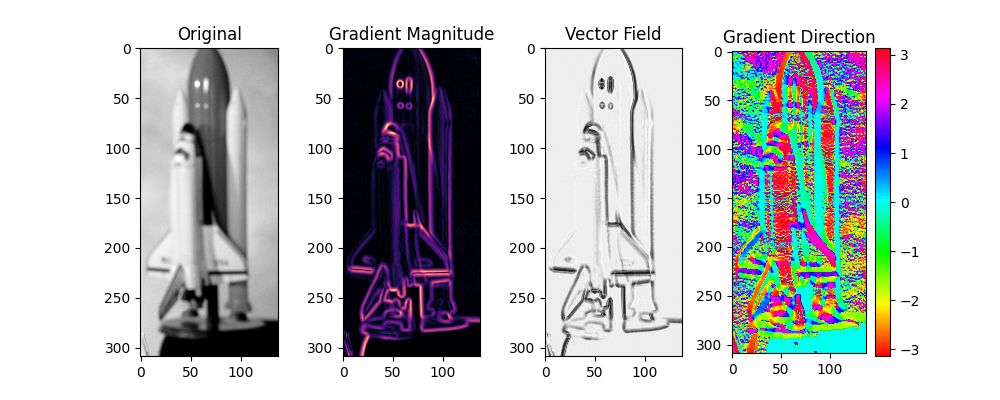

In [38]:
ifig=10; close(ifig);figure(ifig,figsize(10,4))

subplot(1,4,1)
imshow(r[mask], cmap="gray")
title("Original")


subplot(1,4,2, sharex=gca(), sharey=gca())
imshow(gradmag[mask], cmap="magma")
title("Gradient Magnitude")


subplot(1,4,3,sharex=gca(), sharey=gca())
quiver(filteredhoriz[mask], filteredvert[mask],)
gca().set_aspect(1)
title("Vector Field")


subplot(1,4,4, sharex=gca(), sharey=gca())
i = imshow(gradangle[mask], cmap="hsv")
title("Gradient Direction")
# Add colorbar
cbar = gcf().colorbar(i)

That was linear filters.

### Other Filters
There are a wide variety of filters that are very powerful -- for transformations, denoising, removing distortions, even applying "snapchat" filters!

One very useful filter for removing noise  from an image is a **median filter**. This filter replaces each pixel with the median of the surrounding pixels.


Here is an example, sourced from Wikipedia:

<img src="https://upload.wikimedia.org/wikipedia/commons/1/1d/Medianfilterp.png"/>

It is very useful for removing outliers that come from electrical noise in image detectors / camera sensors.

We can use it in python with the `scipy.ndimage.median_filter` function:

In [39]:
scipy.ndimage.median_filter?

Signature:
scipy.ndimage.median_filter(
    input,
    size=None,
    footprint=None,
    output=None,
    mode='reflect',
    cval=0.0,
    origin=0,
)
Docstring:
Calculate a multidimensional median filter.

Parameters
----------
input : array_like
    The input array.
size : scalar or tuple, optional
    See footprint, below. Ignored if footprint is given.
footprint : array, optional
    Either `size` or `footprint` must be defined. `size` gives
    the shape that is taken from the input array, at every element
    position, to define the input to the filter function.
    `footprint` is a boolean array that specifies (implicitly) a
    shape, but also which of the elements within this shape will get
    passed to the filter function. Thus ``size=(n,m)`` is equivalent
    to ``footprint=np.ones((n,m))``.  We adjust `size` to the number
    of dimensions of the input array, so that, if the input array is
    shape (10,10,10), and `size` is 2, then the actual size used is
    (2,2,2). W


<br>

This time, let's use a different famous image: **the Hubble deep field**

In [3]:
img = skimage.data.hubble_deep_field()[:,:,2] # Take the blue channel

Text(0.5, 1.0, 'Median Filter')

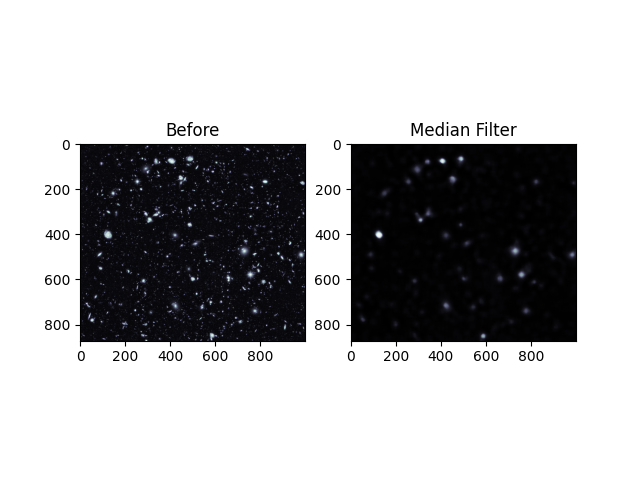

In [7]:
# The second parameter is the number of pixels to look at.
# The larger, the more agressive the filter will be.
medfilt = scipy.ndimage.median_filter(img, 25)


ifig=11; close(ifig);figure(ifig)
subplot(1,2,1)
imshow(img, cmap="bone")
title("Before")

subplot(1,2,2,sharex=gca(), sharey=gca())
imshow(medfilt, cmap="bone")
title("Median Filter")

Notice how all of the foreground stars have been removed? We are left with mostly background galaxies which are the intended targets of this image.

In [42]:
# Zoom into one region to see how stars are removed
xlim((356.56340378198007, 668.0205784204672)), ylim((193.2753058954395, 39.029847979236365))

((356.56340378198007, 668.0205784204672),
 (193.2753058954395, 39.029847979236365))

### Histograms

Histograms are a powerful tool for understanding the distribution of intensity in an image.
Since images are just arrays, we can use the usual statistics and plotting tools we have seen before:

Text(0.5, 0, 'Pixel Value')

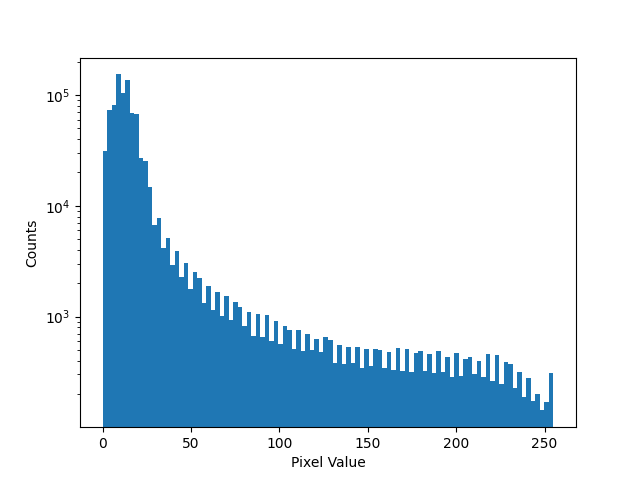

In [8]:
ifig=19; close(ifig); figure(ifig);

hist(reshape(img,img.size), bins=100)
yscale("log")
ylabel("Counts")
xlabel("Pixel Value")

We can find the median and standard deviation like so:

In [9]:
m = median(img)
print("The median of the hubble deep field image is", m)

The median of the hubble deep field image is 12.0


In [10]:
sigma = std(img)
print("The standard deviation (sigma) of the image is", sigma)

The standard deviation (sigma) of the image is 29.13259091492096


This is useful information for displaying scientific images. We can "zoom" in the brightness range right around the most important information.

With `imshow`, there are keyword arguments for this: `vmin` sets the value for the minimum brightness, and `vmax` sets the value for the maximum brightness.

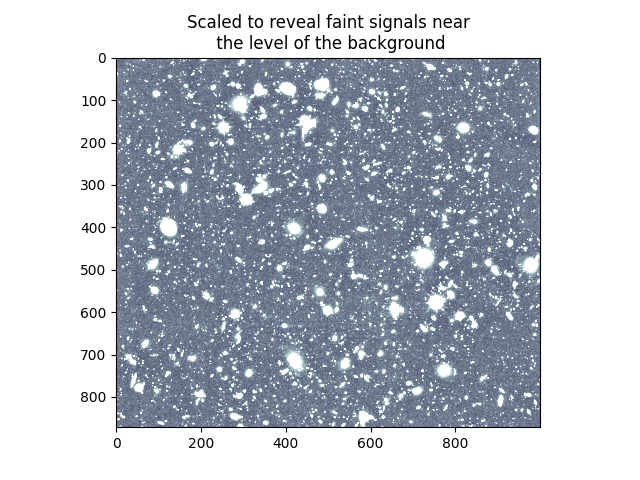

In [11]:

ifig=20; close(ifig);figure(ifig)

imshow(img, cmap="bone", vmin=(m-sigma), vmax=(m+sigma))
title("Scaled to reveal faint signals near\n the level of the background");

## Real world examples
Making an image of exoplanets!



The FITS image format is ubiquitous in astronomy. It can handle data of different precisions and more than 2 dimensions, in addition to metadata.

In [13]:
from astropy.io import fits
hdu = fits.open("Data/HR8799.fits")[0]

Reading header to see metadata:

In [14]:
hdu.header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -64 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  201 / length of data axis 1                          
NAXIS2  =                  201 / length of data axis 2                          
NAXIS3  =                    5 / length of data axis 3                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATEOBS = '2020-11-16'         / Date of the obsevation                         
INST    = 'Keck NIRC2'                                                          

This data cube consists of five images. It is therefore a 5x201x201 "image".

In [15]:
shape(hdu.data)

(5, 201, 201)

Let's extract and plot the first slice

In [16]:
img0 = hdu.data[0,:,:]

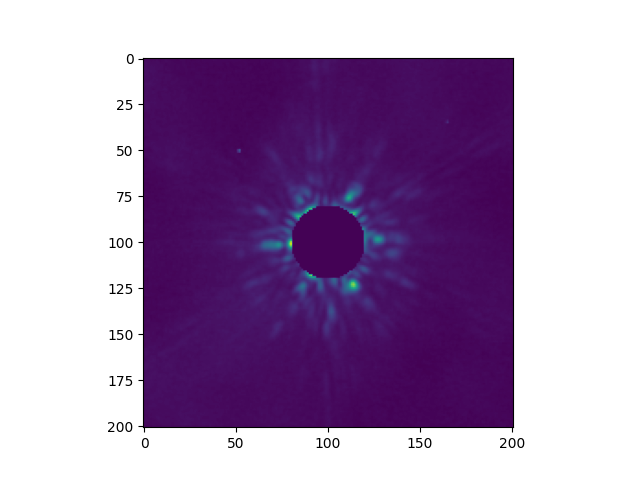

In [17]:
close(101); figure(101)
imshow(img0)

This is an image of the HR8799 planetary system, around 40 parsecs away. This image covers about 4x4 arcseconds, where one arcsecond is 1/60th of 1/60th of one degree in the sky.

The human eye has a resolution of at best around 28 arcseconds for reference.

The inner region has been blocked with a coronagraph to suppress the blinding light of the star.

### Let's look for some exoplanets!

Let's start by viewing the five slices

In [18]:
img0 = hdu.data[0,:,:]
img1 = hdu.data[1,:,:]
img2 = hdu.data[2,:,:]
img3 = hdu.data[3,:,:]
img4 = hdu.data[4,:,:]

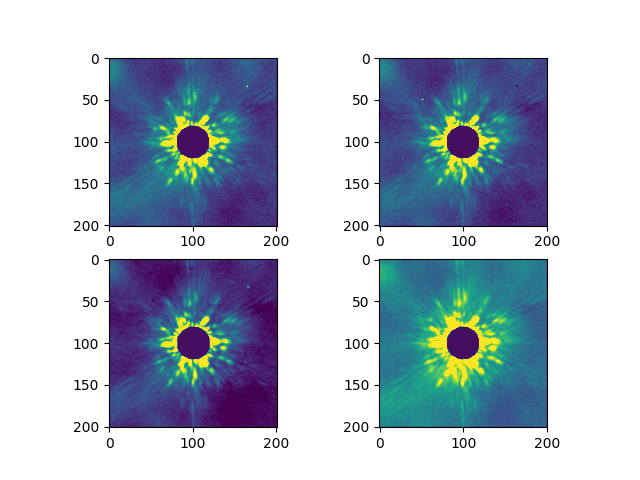

In [19]:
close(103); figure(103)
subplot(2,2,1)
imshow(img1, vmin=-200, vmax=5100)
subplot(2,2,2)
imshow(img2, vmin=-200, vmax=5100)
subplot(2,2,3)
imshow(img3, vmin=-200, vmax=5100)
subplot(2,2,4)
imshow(img4, vmin=-200, vmax=5100)
# tight_layout()

Are there any planets there? Very hard to tell!

Let's pick the middle image, and average the others, and subtract them.

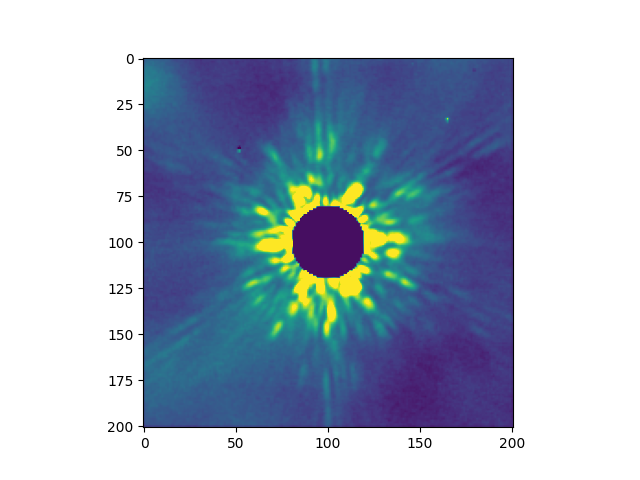

In [20]:
averaged = (img0 + img1 + img3 +img4)/4

close(104); figure(104)
imshow(averaged, vmin=-200, vmax=5100)

Now subtract it

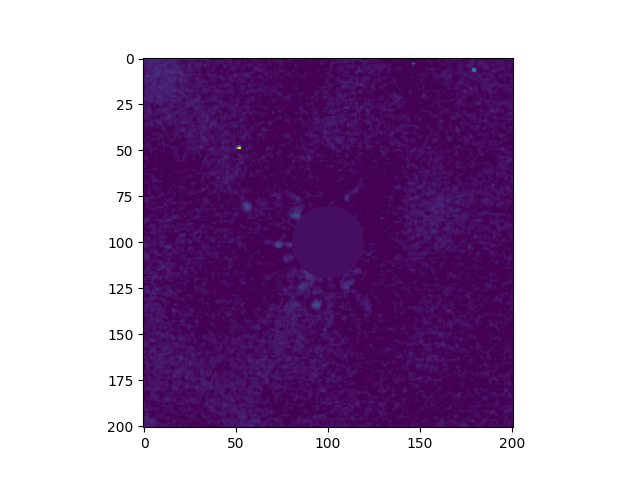

In [21]:
subtracted = img2 - averaged

close(102); figure(102)
imshow(subtracted, vmin=-200, vmax=5100)

Much better! Now adjust the scale:

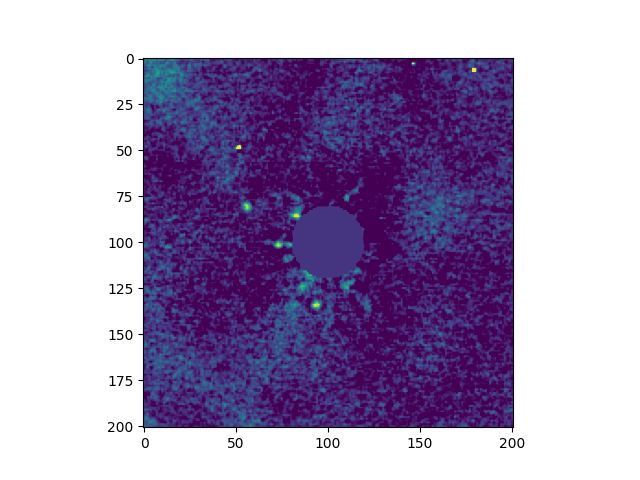

In [22]:

close(102); figure(102)
imshow(subtracted, vmin=-200, vmax=1100)

Now, let's apply a "high-pass filter" to remove the thermal background.

This is a smoothing filter in reverse. To use it, first apply a gaussian blur:

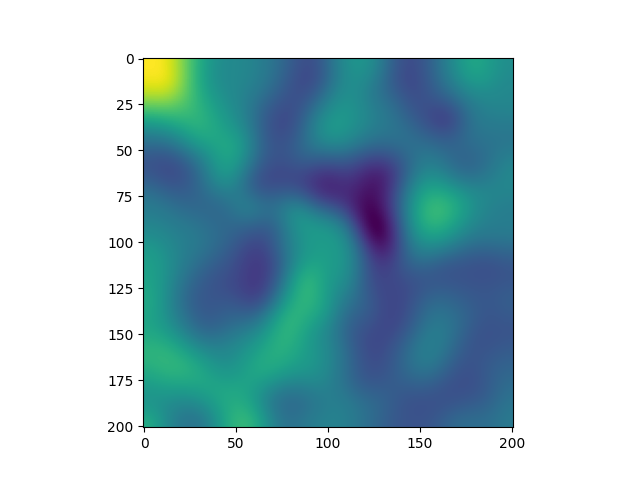

In [23]:
# We'll use a function to generate a large Gaussian kernel
blurred  = scipy.ndimage.gaussian_filter(subtracted, 8)


close(105); figure(105)
imshow(blurred)

Now subtract this blurred image from our original

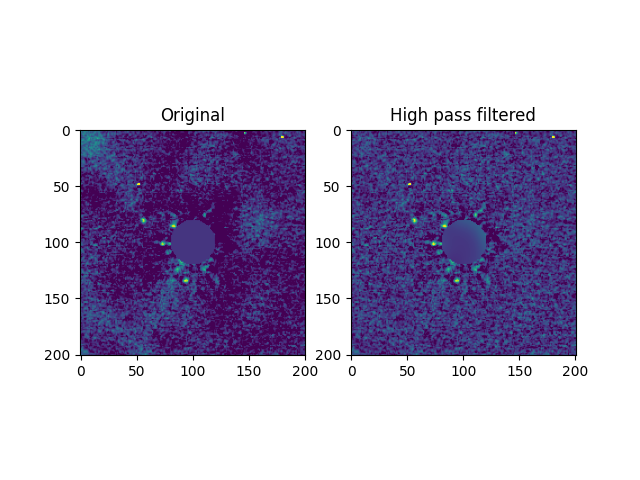

In [24]:
# We'll use a function to generate a large Gaussian kernel
filtered  = subtracted - blurred


close(106); figure(106)
subplot(1,2,1)
title("Original")
imshow(subtracted, vmin=-200, vmax=1100)
subplot(1,2,2)
title("High pass filtered")
imshow(filtered, vmin=-200, vmax=1100)

Ta-da! We see two exoplanets, HR8799 c and d (and maybe e if you squint).

## Assess Detection

Finally, let's assess the signal detection using some basic statistics

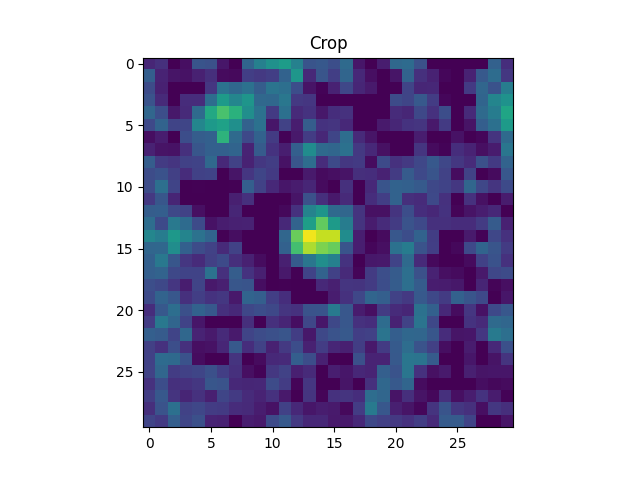

In [25]:
planet_c = filtered[120:150,80:110]

close(107); figure(107)
title("Crop")
imshow(planet_c, vmin=-200, vmax=1100)


First measure the signal strength

In [26]:
signal_strength = np.max(planet_c)
signal_strength

1069.9948173785322

And now the noise using a standard deviation

In [49]:
noise = np.std(planet_c)
noise

212.10164560290912

The significance of the detection is the signal to noise ratio.
Anything over $5\sigma$ is considered valid!

In [51]:
signal_strength/noise

5.044726618395725

We have a confirmed detection of a planet!

## Bonus: Least Squares Reconstruction using Images as a System of Linear Equations

Previously, we subtracted the average of four images to remove the noise. We can do better by constructing a linear combination
of reference images that best matches each image.
This is similar to the math we've seen previously for solving a system of linear equations, only here the images are the rows in our matrix.
Here however, we are over-constrained. We have 161604 equations and 4 unknowns! We will find the least-squares solution.

In [27]:
img0 = hdu.data[0,:,:]#scipy.ndimage.median_filter(hdu.data[0,:,:], 3)
img1 = hdu.data[1,:,:]#scipy.ndimage.median_filter(hdu.data[1,:,:], 3)
img2 = hdu.data[2,:,:]#scipy.ndimage.median_filter(hdu.data[2,:,:], 3)
img3 = hdu.data[3,:,:]#scipy.ndimage.median_filter(hdu.data[3,:,:], 3)
img4 = hdu.data[4,:,:]#scipy.ndimage.median_filter(hdu.data[4,:,:], 3)

mat = np.array([
    np.ndarray.flatten(img0),
    np.ndarray.flatten(img1),
    # np.ndarray.flatten(img2),
    np.ndarray.flatten(img3),
    np.ndarray.flatten(img4),
])
sol = np.linalg.lstsq(mat.T, np.ndarray.flatten(img2))
b = sol[0]
b

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


array([0.06062036, 0.37974124, 0.36212817, 0.18973871])

In [32]:
# Here is our solution, the best combination of images:
reference_vec = np.sum(
    b[:,None] * mat,
    axis=0
)

# We need to un-flatten it back into a square
reference = np.reshape(reference_vec, img0.shape)

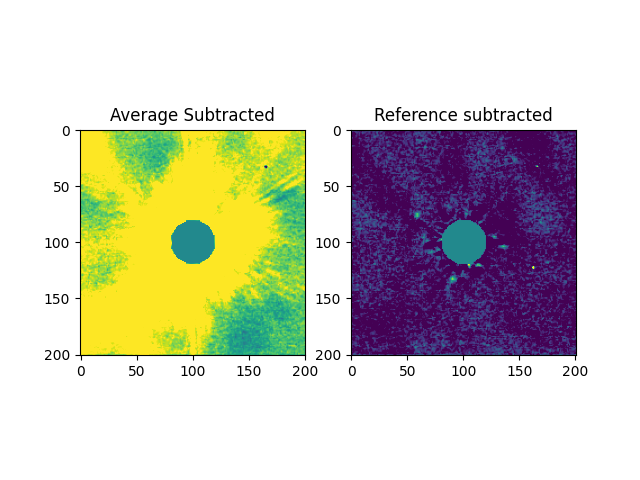

In [33]:
bestsubbed  = img2 - reference

close(108); figure(108)
subplot(1,2,1)
title("Average Subtracted")
imshow(img2, vmin=-1000, vmax=1100)
subplot(1,2,2)
title("Reference subtracted")
imshow(bestsubbed, vmin=-1000, vmax=1100)

## Finally, let's do this in a loop using all the images to calibrate each other:

In [34]:
imgs = [img0, img1, img2, img3, img4]

angles = [
    rad2deg(arctan2(105.5-100,52.8-100)),
    rad2deg(arctan2(84.6-100,54.6-100)),
    rad2deg(arctan2(79-100,56.3-100)),
    rad2deg(arctan2(76-100,59.-100)),
    rad2deg(arctan2(73.9-100,59.-100)),
]

out = []
for i in range(5):
    mat = np.array([
        np.ndarray.flatten(imgs[j])
        for j in range(5) if j != i
    ])
    sol = np.linalg.lstsq(mat.T, np.ndarray.flatten(imgs[i]))
    b = sol[0]
    reference_vec = np.sum(
        b[:,None] * mat,
        axis=0
    )

    # We need to un-flatten it back into a square
    reference = np.reshape(reference_vec, img0.shape)
    bestsubbed = imgs[i] - reference
    
    rotated = scipy.ndimage.rotate(bestsubbed, angles[i], reshape=False)
    out.append(rotated)
stacked = median(array(out),axis=0)
final  = stacked - scipy.ndimage.gaussian_filter(stacked, 8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


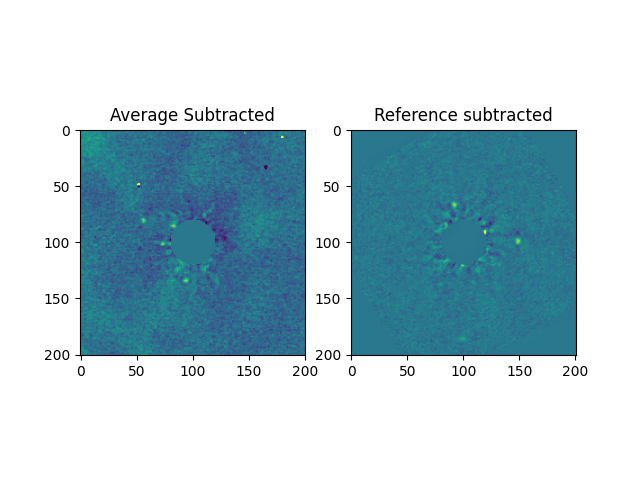

In [35]:

close(109); figure(109)
subplot(1,2,1)
title("Average Subtracted")
imshow(subtracted, vmin=-1000, vmax=1500)
subplot(1,2,2)
title("Reference subtracted")
imshow(final, vmin=-1000, vmax=1500)

### Now we see the third planet!

In [37]:
from astropy.io import fits
hdu = fits.PrimaryHDU(final)
hdul = fits.HDUList([hdu])
hdul.writeto('Data/processed-planets.fits', overwrite=True)